# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation
import warnings
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn import metrics
from sklearn import preprocessing
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

from tqdm import tqdm
import os

c:\users\rahul\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\rahul\\Desktop\\AI COURSE\\Amazon Fine food\\amazon-fine-food-reviews (1)\\database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [7]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [20]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [21]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [22]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [23]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [9]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [10]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [24]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [25]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [26]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [27]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [28]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [29]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [30]:
# Combining all the above stundents 
from tqdm import tqdm

#Before starting the next phase of preprocessing lets see the number of entries left
final = final.sample(n=100000)
final.shape

print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
preprocessed_summary = [] 
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())

(100000, 10)


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:48<00:00, 2041.47it/s]


In [18]:
preprocessed_reviews[1500]

'dog picky comes geenies loves greenies heathy treat helps keep teath clean thank greenies'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [31]:
## Similartly you can do preprocessing for review summary also.
print(preprocessed_summary[1500])

## Take length of each review and use it as a feature
review_len = [len(i) for i in preprocessed_reviews]
#Add summary text and review text to extract as much information as possible
# interlist element concatenation 
combined_text = [i +' '+ j for i, j in zip(preprocessed_reviews, preprocessed_summary)] 

len(review_len)

final['combined_text'] = combined_text
final['review_length'] = review_len

great coffee choice


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [180]:
# Please write all the code with proper documentation
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

label = final['Score']

# split the data set into train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)

type(final)
print(final.head(3))

#Bag of words using Scikit learn
count_vect = CountVectorizer()
vocab = count_vect.fit(X_train['combined_text'].values)
type(vocab)


# #Using the vocab obtained in train to vectorize both train and test data
X_train_bow = vocab.transform(X_train['combined_text'].values)
X_test_bow = vocab.transform(X_test['combined_text'].values)

print(X_train_bow.shape)

X_train_len = X_train['review_length']
X_test_len = X_test['review_length']
X_train_len = X_train_len.values
X_test_len = X_test_len.values

X_train_len = X_train_len.reshape(X_train_len.size,1)
X_test_len = X_test_len.reshape(X_test_len.size,1)


X_train_len = sparse.coo_matrix(X_train_len)
X_test_len = sparse.coo_matrix(X_test_len)

X_trainf = sparse.vstack((X_train_bow.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_bow.T,X_test_len.T)).T

print(X_trainf.shape)
print(X_testf.shape)

            Id   ProductId          UserId   ProfileName  \
360254  389642  B0049MFQ1S   ASKQC46LSLH6Z  SuperShopper   
451179  487825  B0001GZ6GG  A35FHDNYL64RRO   D. Pedrotti   
25080    27387  B007H13SYA  A39ALRPNB46WGH        DCinMI   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
360254                     0                       0      1  1348963200   
451179                     1                       1      1  1196553600   
25080                      2                       2      1  1339977600   

                                   Summary  \
360254  Excellent rehydrating sports drink   
451179                          NectaSweet   
25080                    Can't get enough!   

                                                     Text  \
360254  I LOVE this product! No dyes or horrible stuff...   
451179  No Problem.  This item had not been available ...   
25080   This popcorn is a little pricey, but it's wort...   

                            

In [172]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate


#function to find the optimal lambda in LR for 5 fold cross validation
def find_optimal_lambda(x,y,k,pen,kernel):
    
    c_grid_list = [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]
    gamma_grid_list =  [2**-11,2**-9, 2**-7,2**-5,2**-3,2**-1,2**1,2**3]
    alpha_grid_list = [10**-6,10**-5,10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]

    if(kernel == 'linear'):
        tuned_parameters = [{'alpha': alpha_grid_list}]
        model = GridSearchCV(SGDClassifier(class_weight='balanced',loss='hinge',penalty=pen), tuned_parameters, scoring = 'roc_auc',n_jobs=-1, cv=k,return_train_score = True)
        model.fit(x,y)
        
    train_scores = model.cv_results_['mean_train_score']
    cv_scores = model.cv_results_['mean_test_score']    
    
    
    if(kernel=='linear'):
        optimal_lambda = alpha_grid_list[np.argmax(cv_scores)]
        print('\nThe optimal value of alpha is %f.' % optimal_lambda)
        #taking log of the values for graph to maintain the scale
        log_alpha = np.log(alpha_grid_list)
        plt.figure(figsize=(16,8))

        plt.plot(log_alpha, cv_scores,label='CV_plot for alpha')
        plt.plot(log_alpha, train_scores,label= 'Train_plot for alpha')

        for xy in zip(np.round(log_alpha,3), np.round(cv_scores,3)):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

        for xy in zip(np.round(log_alpha,3), np.round(train_scores,3)):
            plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

        plt.xlabel('Log-Value of alpha ')
        plt.ylabel('AUC Score')
        plt.legend()
        plt.show()

        print("the AUC score for each alpha value is : ", np.round(cv_scores,3))
    
    return model
    
#function to find the optimal alpha in NB for 5 fold cross validation

def find_optimal_lambda_rbf(x,y,k,pen,kernel):
    
    c_grid_list = [10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4,10**5]
    gamma_grid_list =  [10**-5,10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]
    
    tuned_parameters = [{'C': c_grid_list, 'gamma': gamma_grid_list}]
    model = GridSearchCV(SVC(class_weight='balanced',kernel='rbf'), tuned_parameters, scoring = 'roc_auc',n_jobs=-1, cv=k,return_train_score = True)
    model.fit(x,y)
    
    train_scores = model.cv_results_['mean_train_score']
    cv_scores = model.cv_results_['mean_test_score']

    train_scores = np.array(train_scores).reshape(len(c_grid_list), len(gamma_grid_list))
    
    train_scores = np.round(train_scores,3)
    
    print("The Heatmap for Train AUC scores is plotted below: ")
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(train_scores,cbar_kws={'label': 'colorbar title'}, xticklabels=gamma_grid_list, yticklabels=c_grid_list, linewidths=0.5, linecolor='yellow',annot=True,fmt='g',ax=ax)
    ax.set_ylabel('C Values')
    ax.set_xlabel('Gamma Values')
    plt.show()
    
    cv_scores = np.array(cv_scores).reshape(len(c_grid_list), len(gamma_grid_list))
    cv_scores = np.round(cv_scores,3)

    print("The Heatmap for Cross-Validation AUC scores is plotted below: ")
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cv_scores,cbar_kws={'label': 'colorbar title'},xticklabels=gamma_grid_list,yticklabels=c_grid_list, linewidths=0.5, linecolor='yellow',annot=True,fmt='g',ax=ax)
    # X - Y axis labels
    ax.set_ylabel('C Values')
    ax.set_xlabel('Gamma Values')
    plt.show()
    best = model.best_estimator_
    print("The best model obtained from our Gridsearch is: ",best)
    print("The best parameters obtained by our model is: ",model.best_params_)
    print("The AUC score for our model is is: ",np.round(model.best_score_,3))
    
    return model

#function to predict the label of test data and return the same as list 
def pred_test_data(x_tr,y_tr,x_tst,y_tst,model):
        
    # predict the response
    calibrator = CalibratedClassifierCV(model, cv='prefit')
    calibrator.fit(x_tr, y_tr)
    prob = calibrator.predict_proba(x_tst)[:,1]
    
    pred = model.predict(x_tst)
    # evaluate accuracy
    roc = roc_auc_score(y_tst, prob) * 100
    print('\nThe ROC_AUC score of our SVM is: ', np.round(roc,3))
        
    return pred,calibrator

#Function to create Confusion matrix creation and plotting the same
def confusion_heatmap(x,y):
    cnf_mat = confusion_matrix(x,y)
    print("Confusion matrix is : " ,cnf_mat )
    print("The True Positive value is:  ",(cnf_mat[1][1]))
    print("The True Negative value is:  ",(cnf_mat[0][0]))
    print("The False Positive value is:  ",(cnf_mat[1][0]))
    print("The False Negative value is:  ",(cnf_mat[0][1]))
    sns.heatmap(cnf_mat,cbar_kws={'label': 'colorbar title'},cmap='YlGnBu',linewidths=2, linecolor='yellow',annot=True,fmt='g')
    
    
def metric_score(x,y):
    print("The precision score for our model is: ", precision_score(x,y)) 
    print("The f1 score for our model is: ", f1_score(x,y))
    print("The recall score for our model is: ", recall_score(x,y))
    print("The accuracy of our model is: ", accuracy_score(x,y))
        

#Function to plot the the roc_auc curve for train and test data    
def plot_roc_curve(xtrain,prob_train,xtest,prob_test,lin1,lin2,l1,l2):
    train_auc = roc_auc_score(xtrain,prob_train)
    fpr,tpr,_ = roc_curve(xtrain,prob_train)
    plt.figure(figsize=(16,8))
    plt.title('Receiver Operating Characteristic')  
    plt.plot(fpr, tpr, linestyle=lin1, label=l1 )
    test_auc = roc_auc_score(xtest,prob_test)
    fpr,tpr,_ = roc_curve(xtest,prob_test)
    plt.plot(fpr, tpr, linestyle=lin2, label=l2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.legend()
    plt.show()
    
#Function to generate wordcloud given a list of words
def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(relative_scaling = 1.0 ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


Grid Search with L1 penalty

The optimal value of alpha is 0.000001.


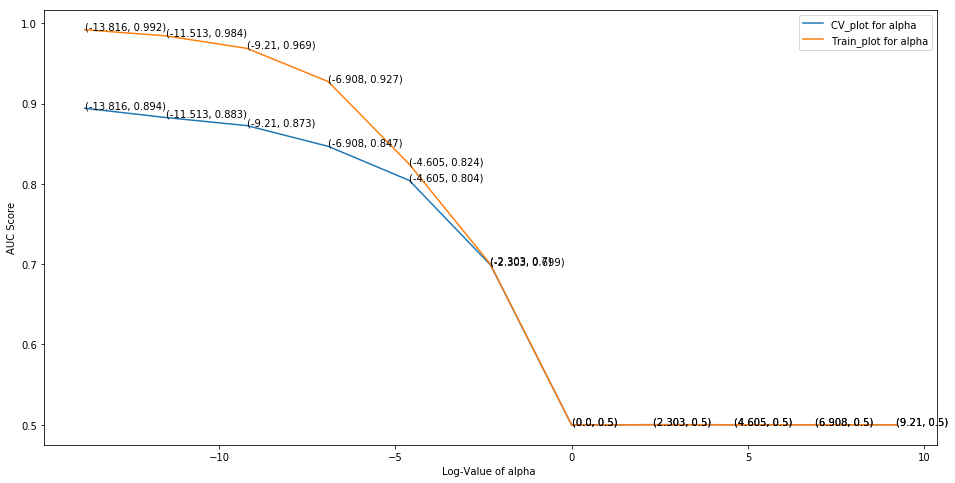

the AUC score for each alpha value is :  [0.894 0.883 0.873 0.847 0.804 0.699 0.5   0.5   0.5   0.5   0.5  ]
Grid Search with L2 penalty

The optimal value of alpha is 1.000000.


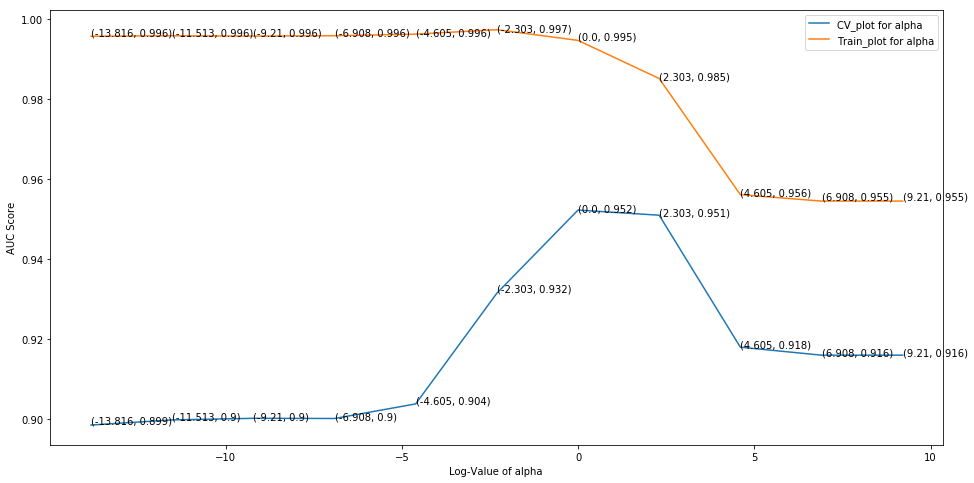

the AUC score for each alpha value is :  [0.899 0.9   0.9   0.9   0.904 0.932 0.952 0.951 0.918 0.916 0.916]


In [182]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_trainf) 
X_trainf = Scaler.transform(X_trainf)
X_testf = Scaler.transform(X_testf) 

# print(X_train)
print("Grid Search with L1 penalty")
opt_plane1 = find_optimal_lambda(X_trainf,y_en_train,5,'l1','linear')
print("Grid Search with L2 penalty")
opt_plane2 = find_optimal_lambda(X_trainf,y_en_train,5,'l2','linear')

In [183]:
#AS we see from above plots that l2 penalty  with alpha value of 1 works best than l2 penalty we will use the same for our model.
opt_plane = SGDClassifier(class_weight='balanced',loss='hinge',penalty='l2',alpha = 1)
opt_plane.fit(X_trainf,y_en_train)

y_pred, model_calibrated = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_plane) 



The ROC_AUC score of our SVM is:  94.57


### Top 10 Positive Features using BOW: ###

The wordcloud for top 10 positive features are:


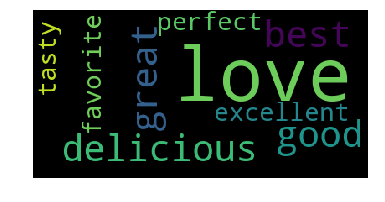

In [184]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS

# neg_class_wt_sorted = np.argsort(coef_org) 
pos_class_wt_sorted = np.argsort(-(opt_plane.coef_))

#Create the top words for each class based on the prob scores obtained for each feature NOTE: we are leaving out first prob score as it corresponds to review length

pos_text = np.take(count_vect.get_feature_names(), pos_class_wt_sorted[:,:10])

pos_text = pos_text.reshape(10)

posi_text = " ".join(words for words in pos_text)
+
print("The wordcloud for top 10 positive features are:")
generate_wordcloud(posi_text)


### Top 10 negative features using BOW ###

The wordcloud for top 10 negative features are:


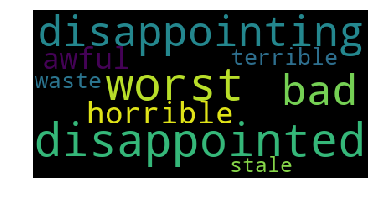

In [185]:
# Please write all the code with proper documentation
# neg_class_prob_sorted = (abs(NB_opt.feature_log_prob_[0, :])).argsort()
neg_class_wt_sorted = np.argsort(opt_plane.coef_)

#Create the top words for each class based on the prob scores obtained for each feature NOTE: we are leaving out first prob score as it corresponds to review length
neg_text = np.take(count_vect.get_feature_names(), neg_class_wt_sorted[:,:10])
neg_text = neg_text.reshape(10)

# neg_text = np.take(count_vect.get_feature_names(), neg_class_prob_sorted[1:11])
nega_text = " ".join(words for words in neg_text)

print("The wordcloud for top 10 negative features are:")
generate_wordcloud(nega_text)

Confusion matrix is :  [[ 3847   800]
 [ 1595 23758]]
The True Positive value is:   23758
The True Negative value is:   3847
The False Positive value is:   1595
The False Negative value is:   800


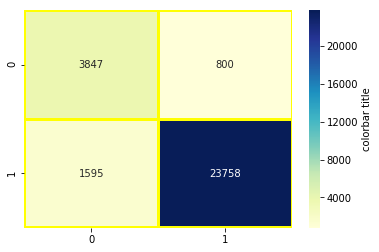

In [186]:
confusion_heatmap(y_en_test,y_pred)

In [187]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9674240573336591
The f1 score for our model is:  0.9520145859630141
The recall score for our model is:  0.9370883130201554
The accuracy of our model is:  0.9201666666666667


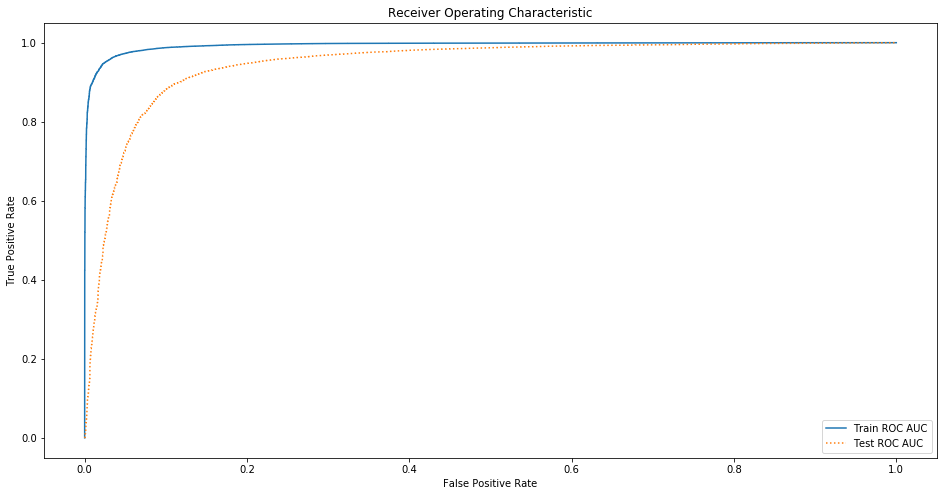

In [188]:
#get the class probabilities for train and test to plot the roc curve 
ytrain_prob = model_calibrated.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = model_calibrated.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]

plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"Train ROC AUC","Test ROC AUC")

Conclusion:
1. SVM using linear kernel with 5-fold validation was performed on a sample dataset of AFF for BOW features.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
3. Confusion matrix was plotted for the same. We got True Negative value of 3847 and True Positive value of 23758.
4. The accuracy,precision, recall and f1 scores are 92.01 % , 96.74%, 93.71% and 95.20 % respectively. 



### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [140]:
# Please write all the code with proper documentation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)
#Converting text into vector using tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab = tf_idf_vect.fit(X_train['combined_text'].values)
X_train_tfidf = vocab.transform(X_train['combined_text'].values)
X_test_tfidf = vocab.transform(X_test['combined_text'].values)

X_trainf = sparse.vstack((X_train_tfidf.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_tfidf.T,X_test_len.T)).T

print(X_trainf.shape)

(70000, 1162143)


Grid Search with L1 penalty
[0.90714225 0.89156839 0.86714224 0.83006082 0.7567343  0.62784345
 0.510927   0.50691365 0.5        0.5        0.5       ]

The optimal value of lambda is 0.000001.


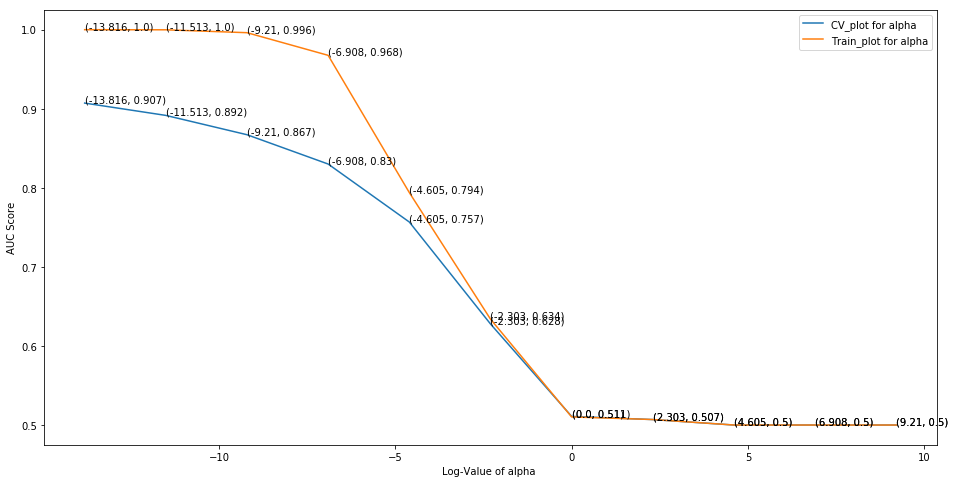

the AUC score for each alpha value is :  [0.907 0.892 0.867 0.83  0.757 0.628 0.511 0.507 0.5   0.5   0.5  ]
Grid Search with L2 penalty
[0.91744538 0.91719556 0.91724271 0.91683551 0.91924411 0.92828399
 0.96524325 0.96116343 0.972212   0.9667417  0.9666711 ]

The optimal value of lambda is 100.000000.


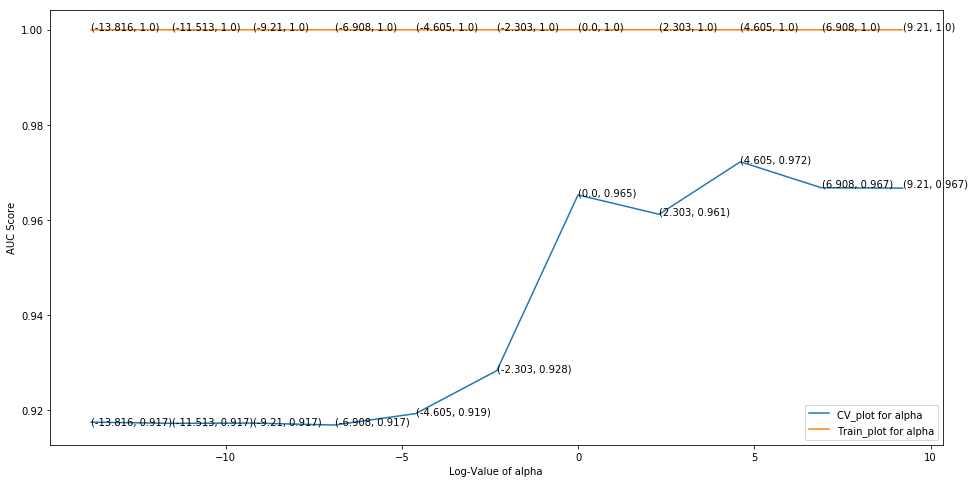

the AUC score for each alpha value is :  [0.917 0.917 0.917 0.917 0.919 0.928 0.965 0.961 0.972 0.967 0.967]


In [141]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_trainf) 
X_trainf = Scaler.transform(X_trainf)
X_testf = Scaler.transform(X_testf) 

# print(X_train)
print("Grid Search with L1 penalty")
opt_plane1 = find_optimal_lambda(X_trainf,y_en_train,5,'l1','linear')
print("Grid Search with L2 penalty")
opt_plane2 = find_optimal_lambda(X_trainf,y_en_train,5,'l2','linear')

In [142]:
#AS we see from above plots that l1 penalty  with alpha value of 0.0001 works better than l2 penalty we will use the same for our model.
opt_plane = SGDClassifier(class_weight='balanced',loss='hinge',penalty='l2',alpha = 100)
opt_plane.fit(X_trainf,y_en_train)

y_pred, model_calibrated = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_plane, 100) 



The ROC_AUC score of linear SVM for lambda = 100.000000 is 96.607907%


The wordcloud for top 10 positive features are:


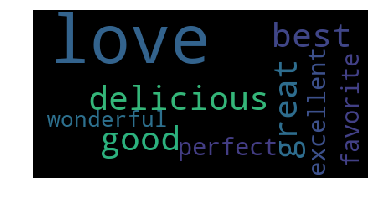

In [143]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS

pos_class_wt_sorted = np.argsort(-(opt_plane.coef_))

#Create the top words for each class based on the weight coefficients associated with each feature 

pos_text = np.take(tf_idf_vect.get_feature_names(), pos_class_wt_sorted[:,:10])

pos_text = pos_text.reshape(10)

posi_text = " ".join(words for words in pos_text)

print("The wordcloud for top 10 positive features are:")
generate_wordcloud(posi_text)


The wordcloud for top 10 negative features are:


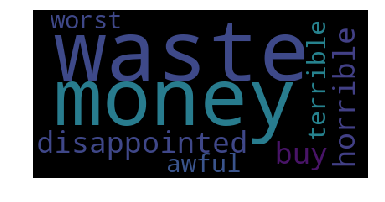

In [144]:
# Please write all the code with proper documentation
neg_class_wt_sorted = np.argsort(opt_plane.coef_)

#Create the top words for each class based on the weight coefficients associated with each feature 
neg_text = np.take(tf_idf_vect.get_feature_names(), neg_class_wt_sorted[:,:10])
neg_text = neg_text.reshape(10)

nega_text = " ".join(words for words in neg_text)

print("The wordcloud for top 10 negative features are:")
generate_wordcloud(nega_text)

Confusion matrix is :  [[ 4354   283]
 [ 3683 21680]]
The True Positive value is:   21680
The True Negative value is:   4354
The False Positive value is:   3683
The False Negative value is:   283


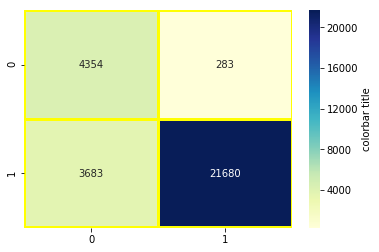

In [145]:
confusion_heatmap(y_en_test,y_pred)

In [147]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9871146928925921
The f1 score for our model is:  0.9161982842412205
The recall score for our model is:  0.8547884713953396
The accuracy of our model is:  0.8678


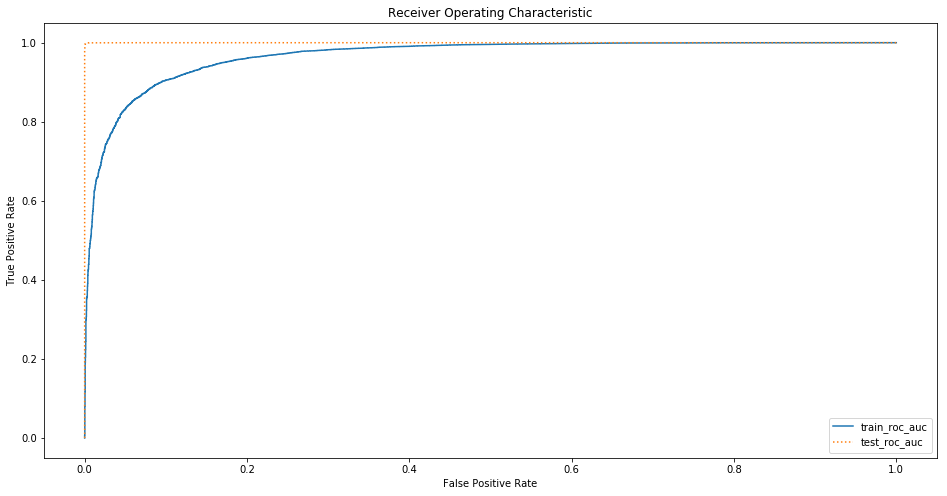

In [146]:

#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(X_trainf,X_testf,'-',':',"train_roc_auc","test_roc_auc")


Conclusion:
1. SVM using linear kernel with 5-fold validation was performed on a sample dataset of AFF for TF-IDF features.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
3. Confusion matrix was plotted for the same. We got True Negative value of 4354 and True Positive value of 21680.
4. The accuracy,precision, recall and f1 scores are 86.78 % , 98.71%, 85.48% and 91.62 % respectively. 



### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [149]:
# Please write all the code with proper documentation
# Train your own Word2Vec model using your own text corpus
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)

i=0


list_of_sentance=[]
for sentance in X_train['combined_text']:
    list_of_sentance.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
sent_train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_train_vectors.append(sent_vec)
print(len(sent_train_vectors))
print(len(sent_train_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [04:56<00:00, 236.11it/s]


70000
50


In [150]:
i=0
list_of_sentance=[]
for sentance in X_test['combined_text']:
    list_of_sentance.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_test_vectors.append(sent_vec)
print(len(sent_test_vectors))
print(len(sent_test_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [02:16<00:00, 219.03it/s]


30000
50


In [154]:
X_train_w2v = np.array(sent_train_vectors)
X_test_w2v = np.array(sent_test_vectors)

X_trainf = sparse.vstack((X_train_w2v.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_w2v.T,X_test_len.T)).T

print(X_trainf.shape)

(70000, 51)


Grid Search with L1 penalty
[0.89832926 0.89966733 0.91443091 0.92863612 0.9292514  0.89557474
 0.5        0.5        0.5        0.5        0.5       ]

The optimal value of lambda is 0.010000.


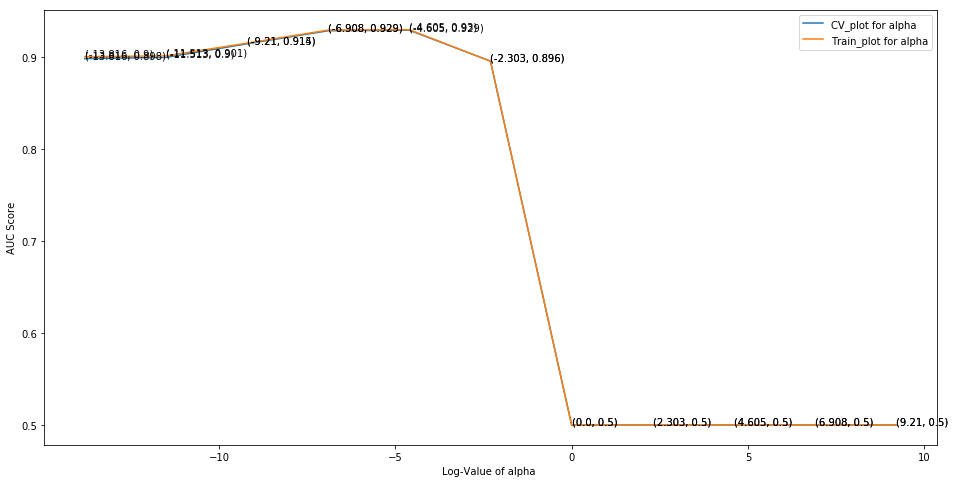

the AUC score for each alpha value is :  [0.898 0.9   0.914 0.929 0.929 0.896 0.5   0.5   0.5   0.5   0.5  ]
Grid Search with L2 penalty
[0.8942559  0.89511518 0.91207711 0.92993296 0.93391501 0.93156878
 0.92313744 0.91243852 0.91238286 0.91238322 0.91238267]

The optimal value of lambda is 0.010000.


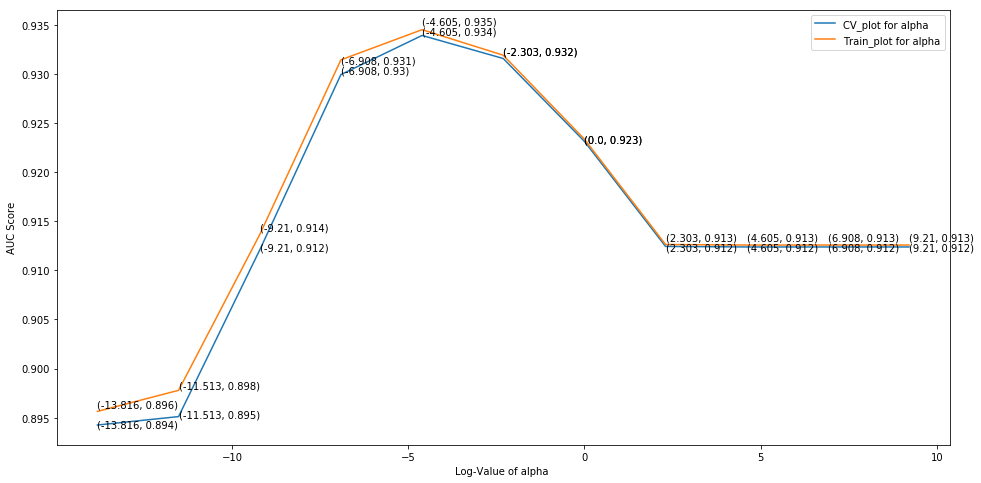

the AUC score for each alpha value is :  [0.894 0.895 0.912 0.93  0.934 0.932 0.923 0.912 0.912 0.912 0.912]


In [155]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_trainf) 
X_trainf = Scaler.transform(X_trainf)
X_testf = Scaler.transform(X_testf) 

# print(X_train)
print("Grid Search with L1 penalty")
opt_plane1 = find_optimal_lambda(X_trainf,y_en_train,5,'l1','linear')
print("Grid Search with L2 penalty")
opt_plane2 = find_optimal_lambda(X_trainf,y_en_train,5,'l2','linear')

In [156]:
#AS we see from above plots that l1 penalty  with alpha value of 0.0001 works better than l2 penalty we will use the same for our model.
opt_plane = SGDClassifier(class_weight='balanced',loss='hinge',penalty='l2',alpha = .01)
opt_plane.fit(X_trainf,y_en_train)

y_pred, model_calibrated = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_plane, .01) 



The ROC_AUC score of linear SVM for lambda = 0.010000 is 93.558050%


Confusion matrix is :  [[ 3938   699]
 [ 3247 22116]]
The True Positive value is:   22116
The True Negative value is:   3938
The False Positive value is:   3247
The False Negative value is:   699


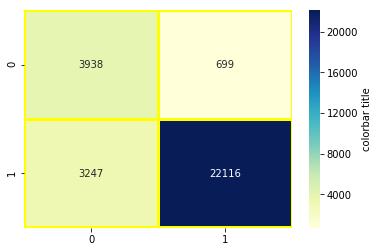

In [157]:
confusion_heatmap(y_en_test,y_pred)

In [158]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.969362261669954
The f1 score for our model is:  0.9180953962389472
The recall score for our model is:  0.8719788668532902
The accuracy of our model is:  0.8684666666666667


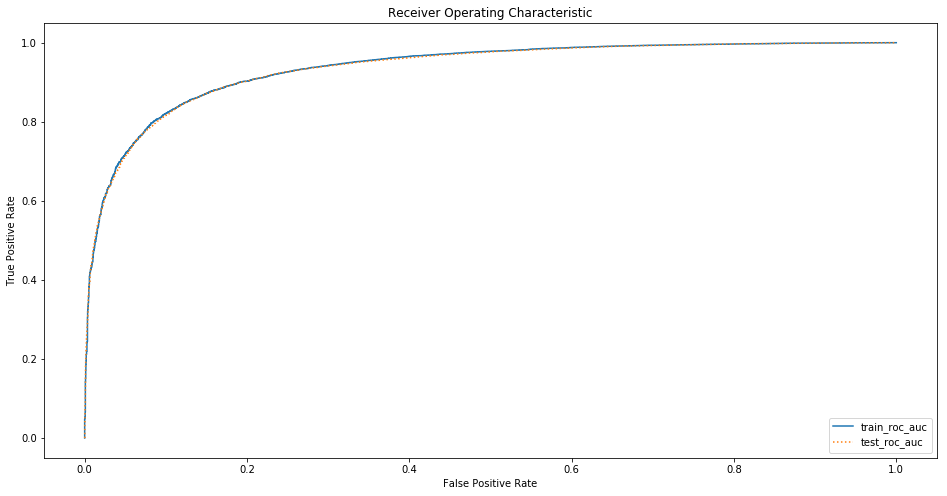

In [172]:
#get the class probabilities for train and test to plot the roc curve 
ytrain_prob = model_calibrated.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = model_calibrated.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]

plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"Train ROC AUC","Test ROC AUC")

Conclusion:
1. SVM using linear kernel with 5-fold validation was performed on a sample dataset of AFF for average w2v.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
3. Confusion matrix was plotted for the same. We got True Negative value of 3398 and True Positive value of 22116.
4. The accuracy,precision, recall and f1 scores are 86.85 % , 96.93%, 87.20% and 91.81 % respectively. 



### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [36]:
# # Please write all the code with proper documentation
# # TF-IDF weighted Word2Vec

final_tf_w2v = final.sample(n=10000)
label_tf_w2v = final_tf_w2v['Score']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final_tf_w2v, label_tf_w2v, test_size=0.3, random_state=0)
#fetching the list of sentences from cleanedtext column of our train data for word2vec model    
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
vocab = tf_idf_vect.fit_transform(X_train['combined_text'].values)
# X_train_tfidf = vocab.transform(X_train['combined_text'].values)
X_test_tfidf = tf_idf_vect.transform(X_test['combined_text'].values)

i=0
list_of_sent=[]
for sent in X_train['combined_text'].values:
    list_of_sent.append(sent.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
    
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
type(X_train)

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;


for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
    
X_train_tfw2v = tfidf_train_vectors



In [38]:
i=0
list_of_sent=[]
for sent in X_test['combined_text'].values:
    list_of_sent.append(sent.split())

tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;


for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
    
X_test_tfw2v = tfidf_test_vectors

In [170]:
X_train_w2v = np.array(tfidf_train_vectors)
X_test_w2v = np.array(tfidf_test_vectors)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(final_tf_w2v, label_tf_w2v, test_size=0.3, random_state=0)
X_train_len = X_train['review_length']
X_test_len = X_test['review_length']
X_train_len = X_train_len.values
X_test_len = X_test_len.values

X_train_len = X_train_len.reshape(X_train_len.size,1)
X_test_len = X_test_len.reshape(X_test_len.size,1)


X_train_len = sparse.coo_matrix(X_train_len)
X_test_len = sparse.coo_matrix(X_test_len)


X_trainf = sparse.vstack((X_train_w2v.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_w2v.T,X_test_len.T)).T

print(X_trainf.shape)

(7000, 51)


Grid Search with L1 penalty

The optimal value of alpha is 0.001000.


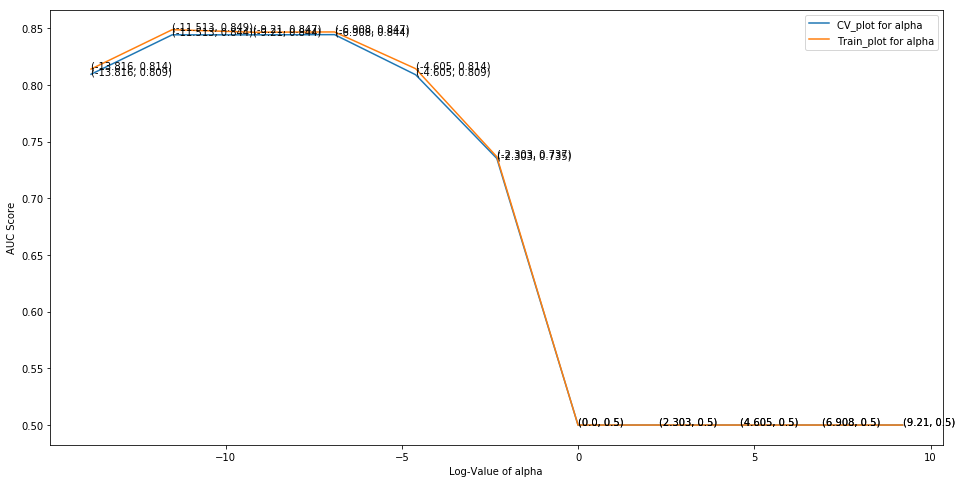

the AUC score for each alpha value is :  [0.809 0.844 0.844 0.844 0.809 0.735 0.5   0.5   0.5   0.5   0.5  ]
Grid Search with L2 penalty

The optimal value of alpha is 0.000100.


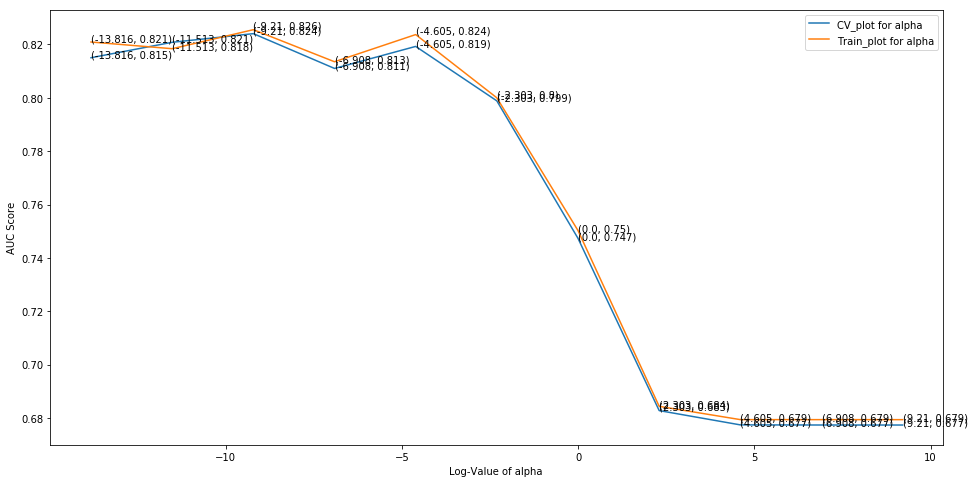

the AUC score for each alpha value is :  [0.815 0.821 0.824 0.811 0.819 0.799 0.747 0.683 0.677 0.677 0.677]


In [173]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_trainf) 
X_trainf = Scaler.transform(X_trainf)
X_testf = Scaler.transform(X_testf) 

# print(X_train)
print("Grid Search with L1 penalty")
opt_plane1 = find_optimal_lambda(X_trainf,y_en_train,5,'l1','linear')
print("Grid Search with L2 penalty")
opt_plane2 = find_optimal_lambda(X_trainf,y_en_train,5,'l2','linear')

In [175]:
#AS we see from above plots that l1 penalty  with alpha value of 0.0001 works better than l2 penalty we will use the l1 for our model.
opt_plane = SGDClassifier(class_weight='balanced',loss='hinge',penalty='l1',alpha = .0001)
opt_plane.fit(X_trainf,y_en_train)

y_pred, model_calibrated = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_plane) 



The ROC_AUC score of our SVM is:  83.273


Confusion matrix is :  [[ 365  119]
 [ 597 1919]]
The True Positive value is:   1919
The True Negative value is:   365
The False Positive value is:   597
The False Negative value is:   119


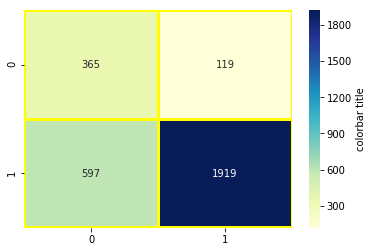

In [176]:
confusion_heatmap(y_en_test,y_pred)

In [177]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9416094210009813
The f1 score for our model is:  0.8427755819060166
The recall score for our model is:  0.7627186009538951
The accuracy of our model is:  0.7613333333333333


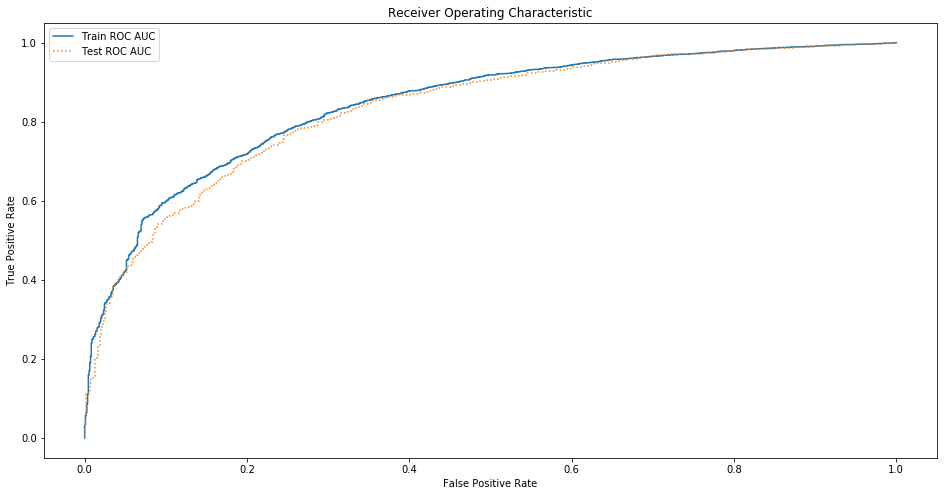

In [179]:
#get the class probabilities for train and test to plot the roc curve 
ytrain_prob = model_calibrated.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = model_calibrated.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]

plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"Train ROC AUC","Test ROC AUC")

Conclusion:
1. SVM using RBF kernel with 2-fold validation was performed on a sample dataset of AFF for TF-IDF average w2v.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
3. Confusion matrix was plotted for the same. We got True Negative value of 365 and True Positive value of 1919.
4. The accuracy,precision, recall and f1 scores are 76.13 % , 94.16%, 76.27% and 76.13 % respectively. 


## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [149]:
# Please write all the code with proper documentation

# Please write all the code with proper documentation
#How many positive and negative reviews are present in our dataset?
final1 = final.sample(n=40000)
final1['Score'].value_counts()

label1 = final1['Score']

# split the data set into train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final1, label1, test_size=0.3, random_state=0)

type(final)
print(final.head(3))

#Bag of words using Scikit learn
count_vect = CountVectorizer(min_df=5,max_features=500)
vocab = count_vect.fit(X_train['combined_text'].values)
type(vocab)


# #Using the vocab obtained in train to vectorize both train and test data
X_train_bow = vocab.transform(X_train['combined_text'].values)
X_test_bow = vocab.transform(X_test['combined_text'].values)

print(X_train_bow.shape)

X_train_len = X_train['review_length']
X_test_len = X_test['review_length']
X_train_len = X_train_len.values
X_test_len = X_test_len.values

X_train_len = X_train_len.reshape(X_train_len.size,1)
X_test_len = X_test_len.reshape(X_test_len.size,1)


X_train_len = sparse.coo_matrix(X_train_len)
X_test_len = sparse.coo_matrix(X_test_len)

X_trainf = sparse.vstack((X_train_bow.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_bow.T,X_test_len.T)).T

print(X_trainf.shape)
print(X_testf.shape)

            Id   ProductId          UserId   ProfileName  \
360254  389642  B0049MFQ1S   ASKQC46LSLH6Z  SuperShopper   
451179  487825  B0001GZ6GG  A35FHDNYL64RRO   D. Pedrotti   
25080    27387  B007H13SYA  A39ALRPNB46WGH        DCinMI   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
360254                     0                       0      1  1348963200   
451179                     1                       1      1  1196553600   
25080                      2                       2      1  1339977600   

                                   Summary  \
360254  Excellent rehydrating sports drink   
451179                          NectaSweet   
25080                    Can't get enough!   

                                                     Text  \
360254  I LOVE this product! No dyes or horrible stuff...   
451179  No Problem.  This item had not been available ...   
25080   This popcorn is a little pricey, but it's wort...   

                            

The Heatmap for Train AUC scores is plotted below: 


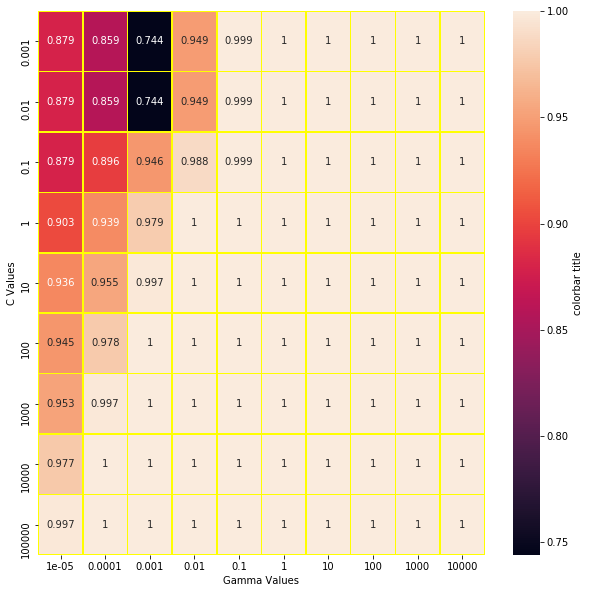

The Heatmap for Cross-Validation AUC scores is plotted below: 


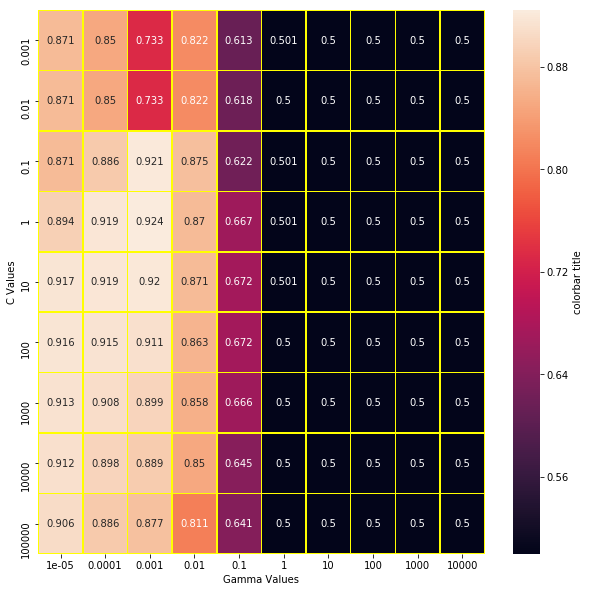

The best model obtained from our Gridsearch is:  SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The best parameters obtained by our model is:  {'C': 1, 'gamma': 0.001}
The AUC score for our model is is:  0.924


In [150]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_trainf) 
X_trainf = Scaler.transform(X_trainf)
X_testf = Scaler.transform(X_testf) 

opt_plane1 = find_optimal_lambda_rbf(x=X_trainf,y=y_en_train,k=2,pen= 'l2',kernel= 'rbf')


In [151]:
#run RBF kernel SVM with best optained parameters in gridsearch
opt_plane = SVC(class_weight='balanced',C=1,gamma=.001,kernel='rbf')
opt_plane.fit(X_trainf,y_en_train)

y_pred, model_calibrated = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_plane) 



The ROC_AUC score of our SVM is:  93.411


Confusion matrix is :  [[1565  327]
 [1256 8852]]
The True Positive value is:   8852
The True Negative value is:   1565
The False Positive value is:   1256
The False Negative value is:   327


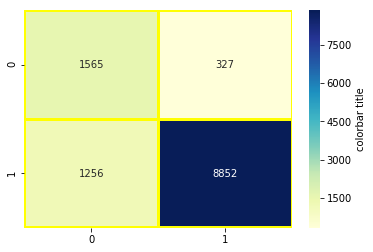

In [152]:
confusion_heatmap(y_en_test,y_pred)

In [153]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9643752042706177
The f1 score for our model is:  0.9179239902525017
The recall score for our model is:  0.8757419865453107
The accuracy of our model is:  0.8680833333333333


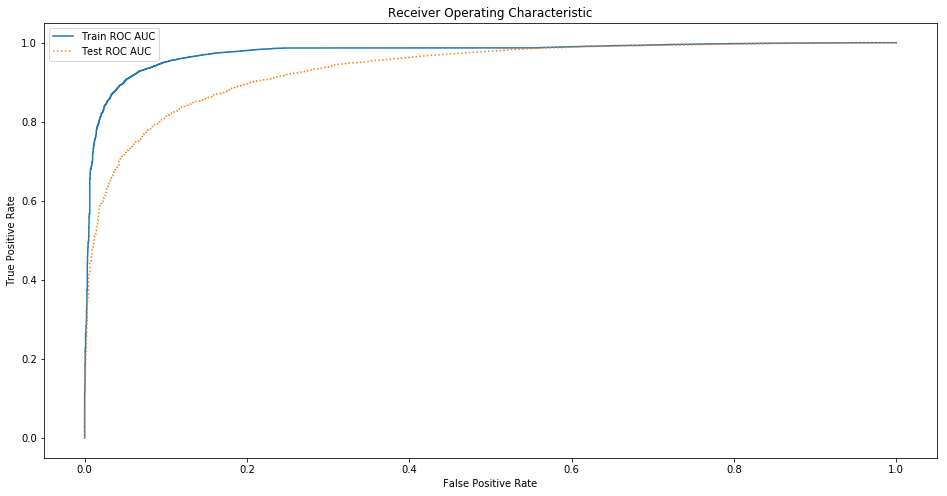

In [154]:
ytrain_prob = model_calibrated.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = model_calibrated.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]

plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"Train ROC AUC","Test ROC AUC")

Conclusion:
1. SVM using RBF kernel with 2-fold validation was performed on a sample dataset of AFF for BOW with features limited to 500.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 1565 and True Positive value of 8852.
5. The accuracy,precision, recall and f1 scores are 86.81 % , 96.44 %, 87.57% and 91.79 % respectively. This means that we are performing remarkabely well in Postive class classification. We get a very high recall value which suggests that most of our classification were correct. 



### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [155]:
# Please write all the code with proper documentation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final1, label1, test_size=0.3, random_state=0)
#Converting text into vector using tfidf vectorizer
tf_idf_vect = TfidfVectorizer(min_df=5,max_features=500,ngram_range=(1,2))
vocab = tf_idf_vect.fit(X_train['combined_text'].values)
X_train_tfidf = vocab.transform(X_train['combined_text'].values)
X_test_tfidf = vocab.transform(X_test['combined_text'].values)

X_trainf = sparse.vstack((X_train_tfidf.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_tfidf.T,X_test_len.T)).T

print(X_trainf.shape)

(28000, 501)


The Heatmap for Train AUC scores is plotted below: 


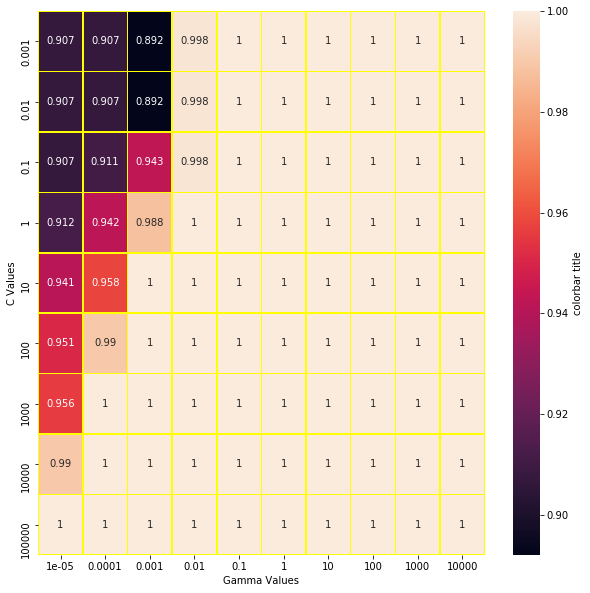

The Heatmap for Cross-Validation AUC scores is plotted below: 


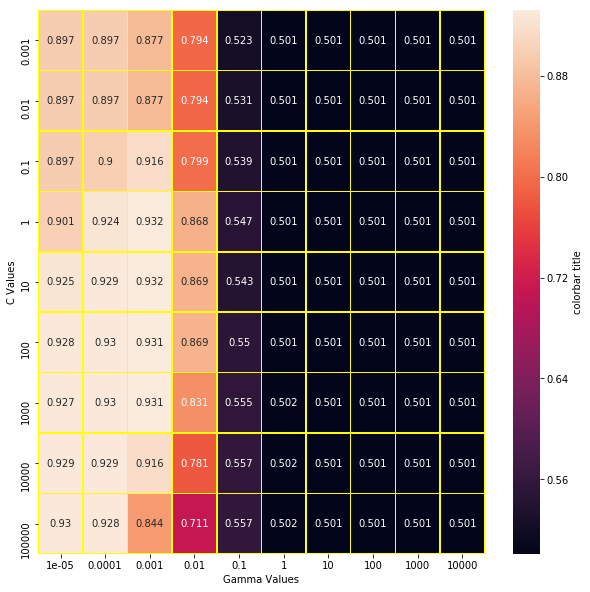

The best model obtained from our Gridsearch is:  SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The best parameters obtained by our model is:  {'C': 10, 'gamma': 0.001}
The AUC score for our model is is:  0.932


In [157]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_trainf) 
X_trainf = Scaler.transform(X_trainf)
X_testf = Scaler.transform(X_testf) 

# x,y,k,pen,kernel
# print(X_train)
# print("Grid Search with L1 penalty")
opt_plane1 = find_optimal_lambda_rbf(x=X_trainf,y=y_en_train,k=2,pen= 'l2',kernel= 'rbf')
# print("Grid Search with L2 penalty")
# opt_plane2 = find_optimal_lambda(X_trainf,y_en_train,5,'l2','rbf')

In [158]:
#run RBF kernel SVM with best optained parameters in gridsearch
opt_plane = SVC(class_weight='balanced',C=10,gamma=.001,kernel='rbf')
opt_plane.fit(X_trainf,y_en_train)

y_pred, model_calibrated = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_plane) 



The ROC_AUC score of our SVM is:  94.172


Confusion matrix is :  [[1230  662]
 [ 377 9731]]
The True Positive value is:   9731
The True Negative value is:   1230
The False Positive value is:   377
The False Negative value is:   662


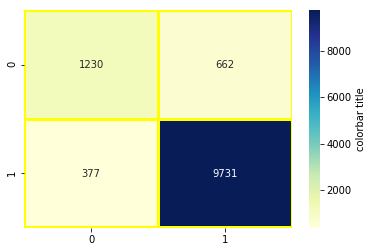

In [159]:
confusion_heatmap(y_en_test,y_pred)

In [160]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.936303281054556
The f1 score for our model is:  0.9493195453880299
The recall score for our model is:  0.9627028096557182
The accuracy of our model is:  0.9134166666666667


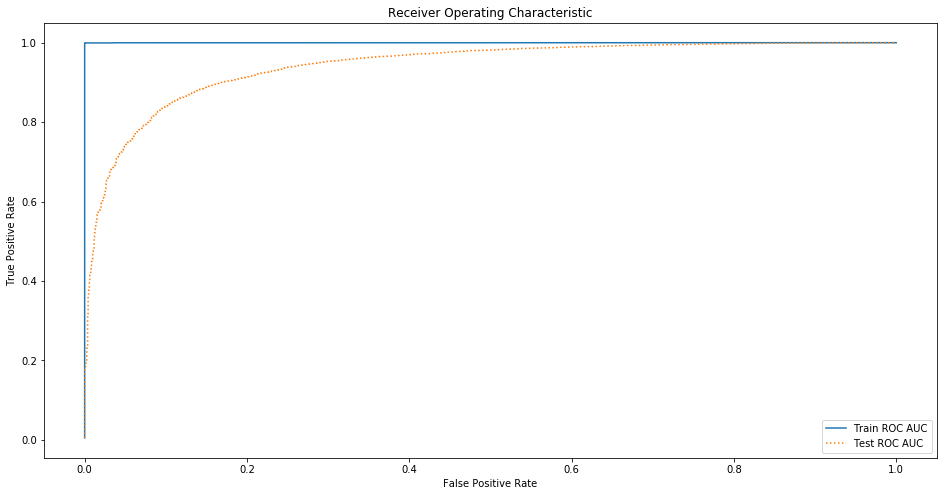

In [161]:
ytrain_prob = model_calibrated.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = model_calibrated.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]

plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"Train ROC AUC","Test ROC AUC")

Conclusion:
1. SVM using RBF kernel with 2-fold validation was performed on a sample dataset of AFF for TF-IDF with features limited to 500.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 1230 and True Positive value of 9731.
5. The accuracy,precision, recall and f1 scores are 91.34 % , 93.63%, 96.27% and 94.93 % respectively. This means that we are performing remarkabely well in Postive class classification. We get a very high recall value which suggests that most of our classification were correct. 



### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [162]:
# Please write all the code with proper documentation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final1, label1, test_size=0.3, random_state=0)

i=0

list_of_sentance=[]
for sentance in X_train['combined_text']:
    list_of_sentance.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
sent_train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_train_vectors.append(sent_vec)
print(len(sent_train_vectors))
print(len(sent_train_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 28000/28000 [01:28<00:00, 316.37it/s]


28000
50


In [163]:
i=0
list_of_sentance=[]
for sentance in X_test['combined_text']:
    list_of_sentance.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_test_vectors.append(sent_vec)
print(len(sent_test_vectors))
print(len(sent_test_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 12000/12000 [00:40<00:00, 295.24it/s]


12000
50


In [164]:
X_train_w2v = np.array(sent_train_vectors)
X_test_w2v = np.array(sent_test_vectors)

X_trainf = sparse.vstack((X_train_w2v.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_w2v.T,X_test_len.T)).T

print(X_trainf.shape)

(28000, 51)


The Heatmap for Train AUC scores is plotted below: 


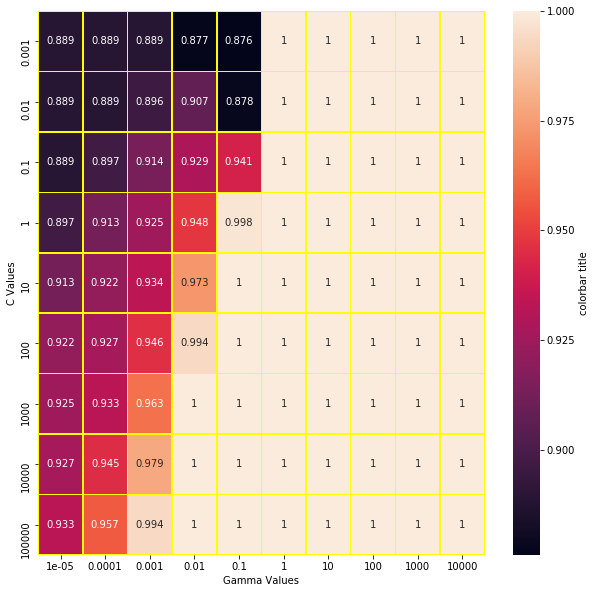

The Heatmap for Cross-Validation AUC scores is plotted below: 


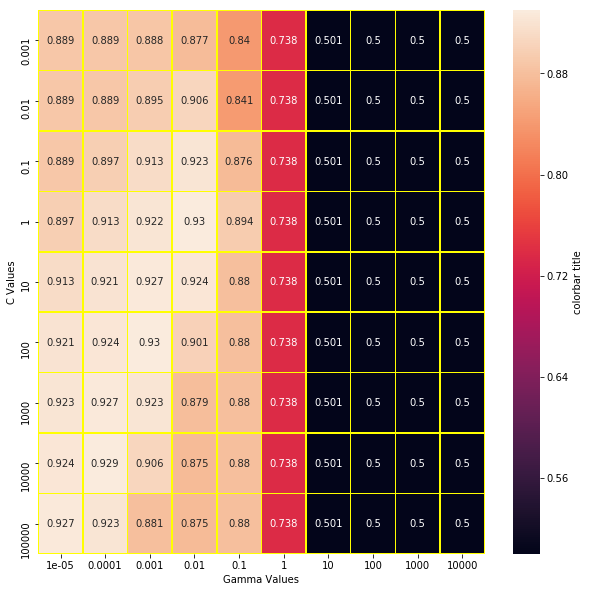

The best model obtained from our Gridsearch is:  SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The best parameters obtained by our model is:  {'C': 1, 'gamma': 0.01}
The AUC score for our model is is:  0.93


In [165]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)


Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_trainf) 
X_trainf = Scaler.transform(X_trainf)
X_testf = Scaler.transform(X_testf) 

# x,y,k,pen,kernel
# print(X_train)
# print("Grid Search with L1 penalty")
opt_plane1 = find_optimal_lambda_rbf(x=X_trainf,y=y_en_train,k=2,pen= 'l2',kernel= 'rbf')
# print("Grid Search with L2 penalty")
# opt_plane2 = find_optimal_lambda(X_trainf,y_en_train,5,'l2','rbf')

In [166]:
#run RBF kernel SVM with best optained parameters in gridsearch
opt_plane = SVC(class_weight='balanced',C=1,gamma=.01,kernel='rbf')
opt_plane.fit(X_trainf,y_en_train)

y_pred, model_calibrated = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_plane) 



The ROC_AUC score of our SVM is:  93.278


Confusion matrix is :  [[1636  256]
 [1555 8553]]
The True Positive value is:   8553
The True Negative value is:   1636
The False Positive value is:   1555
The False Negative value is:   256


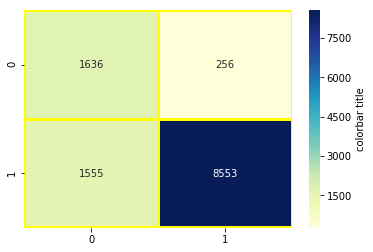

In [167]:
confusion_heatmap(y_en_test,y_pred)

In [168]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9709388125780452
The f1 score for our model is:  0.9042660041232754
The recall score for our model is:  0.8461614562722596
The accuracy of our model is:  0.8490833333333333


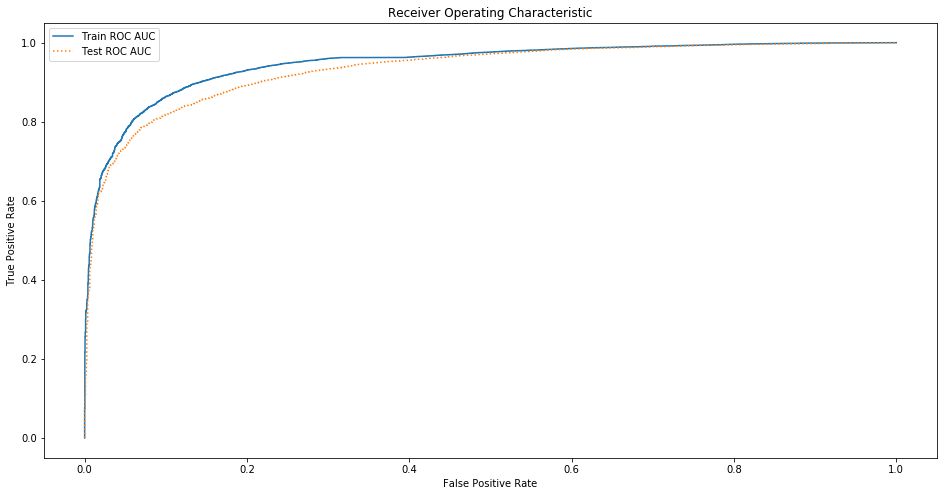

In [169]:
ytrain_prob = model_calibrated.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = model_calibrated.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]

plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"Train ROC AUC","Test ROC AUC")

Conclusion:
1. SVM using RBF kernel with 2-fold validation was performed on a sample dataset of AFF for average word2vec.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 1636 and True Positive value of 8553.
5. The accuracy,precision, recall and f1 scores are 84.91 % , 97.09%, 84.61% and 90.43 % respectively. This means that we are performing remarkabely well in Postive class classification. We get a very high recall value which suggests that most of our classification were correct. 


### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [143]:
# Please write all the code with proper documentation
X_train_w2v = np.array(tfidf_train_vectors)
X_test_w2v = np.array(tfidf_test_vectors)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(final_tf_w2v, label_tf_w2v, test_size=0.3, random_state=0)
X_train_len = X_train['review_length']
X_test_len = X_test['review_length']
X_train_len = X_train_len.values
X_test_len = X_test_len.values

X_train_len = X_train_len.reshape(X_train_len.size,1)
X_test_len = X_test_len.reshape(X_test_len.size,1)


X_train_len = sparse.coo_matrix(X_train_len)
X_test_len = sparse.coo_matrix(X_test_len)


X_trainf = sparse.vstack((X_train_w2v.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_w2v.T,X_test_len.T)).T

print(X_trainf.shape)

(7000, 51)


The Heatmap for Train AUC scores is plotted below: 


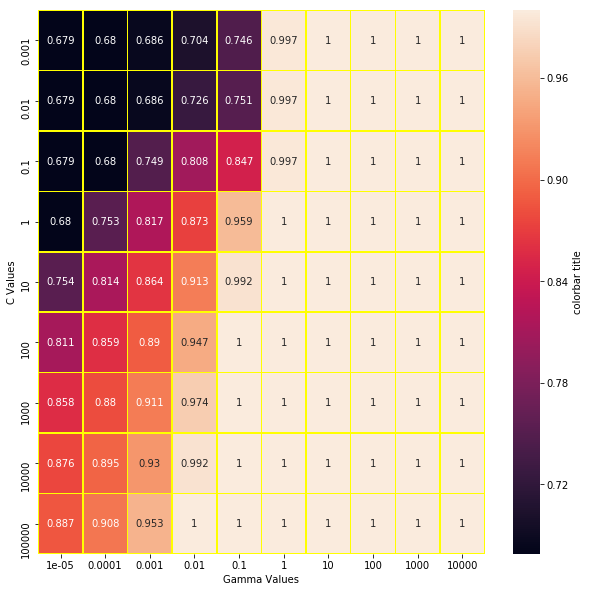

The Heatmap for Cross-Validation AUC scores is plotted below: 


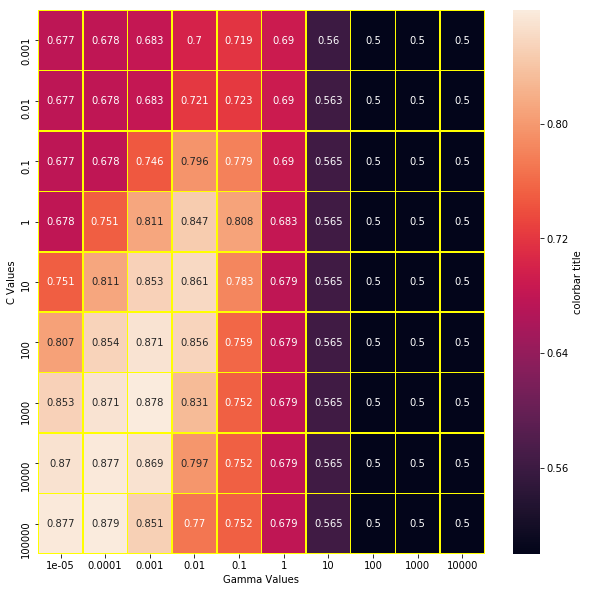

The best model obtained from our Gridsearch is:  SVC(C=100000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
The best parameters obtained by our model is:  {'C': 100000, 'gamma': 0.0001}
The AUC score for our model is is:  0.879


In [144]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

Scaler = StandardScaler(copy=True, with_mean=False, with_std=True).fit(X_trainf) 
X_trainf = Scaler.transform(X_trainf)
X_testf = Scaler.transform(X_testf) 

# print(X_train)
opt_plane1 = find_optimal_lambda_rbf(x=X_trainf,y=y_en_train,k=5,pen= 'l2',kernel= 'rbf')

In [145]:
#run RBF kernel SVM with best optained parameters in gridsearch
opt_plane = SVC(class_weight='balanced',C=100000,gamma=.0001,kernel='rbf')
opt_plane.fit(X_trainf,y_en_train)

y_pred, model_calibrated = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_plane) 



The ROC_AUC score of our SVM is:  88.418


Confusion matrix is :  [[ 384  100]
 [ 484 2032]]
The True Positive value is:   2032
The True Negative value is:   384
The False Positive value is:   484
The False Negative value is:   100


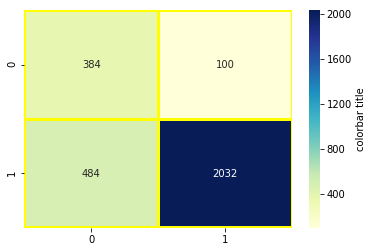

In [146]:
confusion_heatmap(y_en_test,y_pred)

In [147]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9530956848030019
The f1 score for our model is:  0.874354561101549
The recall score for our model is:  0.8076311605723371
The accuracy of our model is:  0.8053333333333333


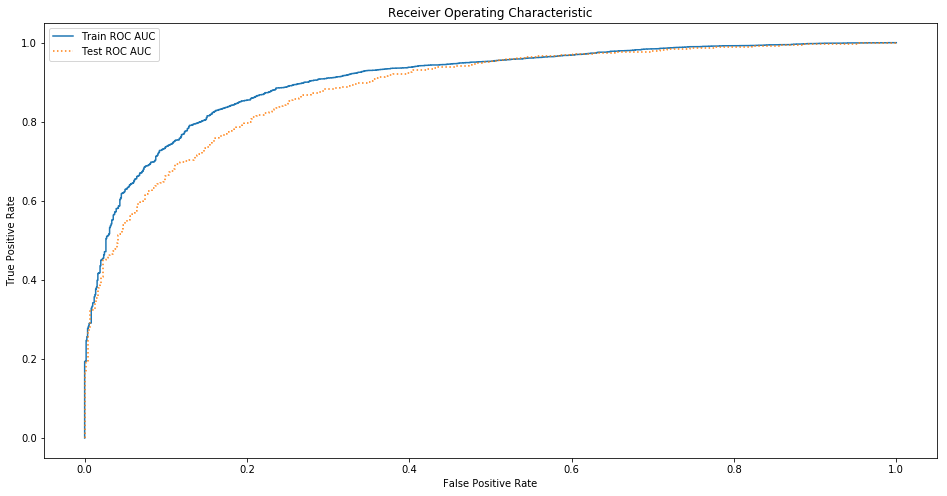

In [148]:
ytrain_prob = model_calibrated.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = model_calibrated.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]

plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"Train ROC AUC","Test ROC AUC")

Conclusion:
1. SVM using RBF kernel with 5-fold validation was performed on a sample dataset of AFF for tf-idf average word2vec.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 384 and True Positive value of 2032.
5. The accuracy,precision, recall and f1 scores are 80.53 % , 95.31%, 80.76% and 87.43 % respectively. This means that we are performing remarkabely well in Postive class classification. We get a very high recall value which suggests that most of our classification were correct. 


# [6] Conclusions

In [189]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
    
x = PrettyTable(["METRIC", "B.O.W", "TF-IDF", "Avg w2v", "TF-IDF w2v", "Kernel" ])

x.add_row(["Alpha",1, 100,0.01,.0001,"Linear" ])
x.add_row(["True Positive",23758, 21680,22116,1919,"Linear" ])
x.add_row(["True Negative",3847,4354,3938,365,"Linear" ])
x.add_row(["Accuracy",92.02, 86.78,86.85,76.13,"Linear" ])
x.add_row(["Precision",96.74, 98.71,96.94,94.16,"Linear" ])
x.add_row(["Recall",93.71, 85.48,87.12,76.27,"Linear" ])
x.add_row(["F1 Scores",95.20,91.62,91.81,84.28,"Linear" ])
x.add_row(["AUC Scores",94.57, 96.61,93.56,83.27,"Linear" ])
x.add_row(["C",1, 10,1,100000,"rbf" ])
x.add_row(["Gamma",.001,.001,0.01,.0001,"rbf" ])
x.add_row(["True Positive",8852, 9731,8553,2032,"rbf" ])
x.add_row(["True Negative",1565,1230,1636,384,"rbf" ])
x.add_row(["Accuracy",86.81,91.34,84.91,80.53,"rbf" ])
x.add_row(["Precision",96.44, 93.63,97.09,95.31,"rbf" ])
x.add_row(["Recall",87.57, 96.27,84.61,80.76,"rbf" ])
x.add_row(["F1 Scores",91.80,94.93,90.43,87.43,"rbf" ])
x.add_row(["AUC Scores",93.41, 94.17,93.28,88.41,"rbf" ])

print(x)

+---------------+-------+--------+---------+------------+--------+
|     METRIC    | B.O.W | TF-IDF | Avg w2v | TF-IDF w2v | Kernel |
+---------------+-------+--------+---------+------------+--------+
|     Alpha     |   1   |  100   |   0.01  |   0.0001   | Linear |
| True Positive | 23758 | 21680  |  22116  |    1919    | Linear |
| True Negative |  3847 |  4354  |   3938  |    365     | Linear |
|    Accuracy   | 92.02 | 86.78  |  86.85  |   76.13    | Linear |
|   Precision   | 96.74 | 98.71  |  96.94  |   94.16    | Linear |
|     Recall    | 93.71 | 85.48  |  87.12  |   76.27    | Linear |
|   F1 Scores   |  95.2 | 91.62  |  91.81  |   84.28    | Linear |
|   AUC Scores  | 94.57 | 96.61  |  93.56  |   83.27    | Linear |
|       C       |   1   |   10   |    1    |   100000   |  rbf   |
|     Gamma     | 0.001 | 0.001  |   0.01  |   0.0001   |  rbf   |
| True Positive |  8852 |  9731  |   8553  |    2032    |  rbf   |
| True Negative |  1565 |  1230  |   1636  |    384     |  rbf